,location,time,day,hour,sep_hour,location_name
0,0,00:00:00,0,0,0,Master bedroom
1,0,00:01:00,0,0,0,Master bedroom
2,0,00:02:00,0,0,0,Master bedroom
3,0,00:03:00,0,0,0,Master bedroom
4,0,00:04:00,0,0,0,Master bedroom


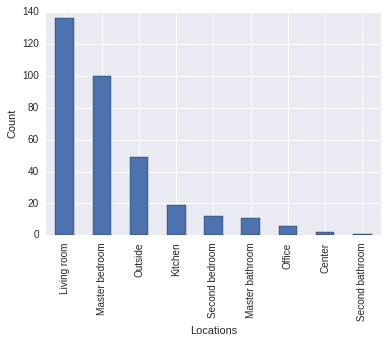

In [1]:
%run LoadAndReduceData.py

dataset.head()

In [49]:

eval_results = pd.DataFrame(columns=['Proportion', 'Accuracy', 'Model'])
eval_results.loc[len(eval_results)] = [1 ,1 ,1]
eval_results


,Proportion,Accuracy,Model
0,1.0,1.0,1.0


In [57]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
# We only take the two corresponding features
X = dataset['sep_hour'].as_matrix()
y = dataset['location'].as_matrix()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          #RandomForestClassifier(n_estimators=n_estimators),
          #ExtraTreesClassifier(n_estimators=n_estimators),
          SVC(kernel='rbf', probability=True)]
          #AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
          #                   n_estimators=n_estimators)]
        

eval_results = pd.DataFrame(columns=['Proportion', 'Accuracy', 'Model'])
for tt_size in [0.003, 0.05, 0.1]:
    for count in np.arange(3):
        for model_num, model in enumerate(models):
           
            # Shuffle
            idx = np.arange(X.shape[0])
            RANDOM_SEED += 1
            np.random.seed(RANDOM_SEED)
            np.random.shuffle(idx)
            X = X[idx]
            y = y[idx]

            #Reshape as only single feature
            X = X.reshape(-1,1)
            # Standardize
            #mean = X.mean(axis=0)
            #std = X.std(axis=0)
            #X = (X - mean) / std

            #split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-tt_size)

            # Train
            clf = clone(model)
            clf = model.fit(X_train, y_train)

            scores = clf.score(X_test, y_test)
            # Create a title for each column and the console by using str() and
            # slicing away useless parts of the string
            model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
            model_details = model_title
            if hasattr(model, "estimators_"):
                model_details += " with {} estimators".format(len(model.estimators_))
            print( model_details + "has a score of", scores )

            eval_results.loc[len(eval_results)] = [tt_size , scores , model_num]

    print('Number of observations : {} and proportion of training {}'.format(y_train.shape, tt_size))

DecisionTreehas a score of 0.639669894339
has a score of 0.648102887492
DecisionTreehas a score of 0.627393545899
has a score of 0.649066835824
DecisionTreehas a score of 0.644725958818
has a score of 0.653320646529
Number of observations : (483,) and proportion of training 0.003
DecisionTreehas a score of 0.653613199666
has a score of 0.652666823308
DecisionTreehas a score of 0.653110641186
has a score of 0.652386173768
DecisionTreehas a score of 0.653097587719
has a score of 0.653143274854
Number of observations : (8064,) and proportion of training 0.05
DecisionTreehas a score of 0.653893849206
has a score of 0.653852513228
DecisionTreehas a score of 0.653211805556
has a score of 0.652674437831
DecisionTreehas a score of 0.653328924162
has a score of 0.653287588183
Number of observations : (16128,) and proportion of training 0.1


In [77]:
eval_results[eval_results['Model'] == 0.0]
eval_results.loc[eval_results['Model'].isin(0.0, 1.0)]
eval_results = eval_results.sample(frac=1).reset_index(drop=True)
sns.factorplot(x="Proportion", y="Accuracy", hue="Model", data=eval_results[eval_results['Model'] == [0.0, 1.0]]);

TypeError: isin() takes 2 positional arguments but 3 were given

In [17]:
model =  RandomForestClassifier(n_estimators=n_estimators)
tt_size = 0.003
for i in range(10):
    X = dataset['sep_hour'].as_matrix()
    y = dataset['location'].as_matrix()


    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    #Reshape as only single feature
    X = X.reshape(-1,1)
    # Standardize
    #mean = X.mean(axis=0)
    #std = X.std(axis=0)
    #X = (X - mean) / std

    #split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-tt_size)

    # Train
    clf = clone(model)
    clf = model.fit(X_train, y_train)

    scores = clf.score(X_test, y_test)
    # Create a title for each column and the console by using str() and
    # slicing away useless parts of the string
    model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
    model_details = model_title
    if hasattr(model, "estimators_"):
        model_details += " with {} estimators".format(len(model.estimators_))
    print( model_details + "has a score of", scores ) 

RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483
RandomForest with 30 estimatorshas a score of 0.634794181483


In [18]:
from bayespy import nodes 
from bayespy.inference import VB 
from scipy.stats import entropy
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import normalize

In [60]:
class DirichletCategoricalModel(object):
    """Bayesian learning for Dirichlet-Categorical Model. 
    
    Attributes:
        
    """
    def __init__(self):
        #Some constants
        self.n_locations = len(location_names.values())
        self.n_timezones = 24 
        
        self.alpha = np.ones(self.n_locations)*0.01
        self.p_theta = nodes.Dirichlet( self.alpha,
                                   plates=(self.n_timezones,),
                                   name='p_theta')
        
    def fit(self, X, y):


        #Taking readings of sep_hour as we know the time in which the reading was taken
        #Reshaing it meet th plates
        recordings_time = X
        self.locations = nodes.Mixture(recordings_time, nodes.Categorical, self.p_theta)
        self.locations.observe(y.reshape(-1,1))
        Q = VB(self.locations, self.p_theta)
        Q.update(repeat=1000)
        self.learned_params = np.array(self.p_theta.get_parameters()).reshape((24,10))
      
    def score(self, X, y):
        df = pd.DataFrame({'sep_hour':X[:,0], 'location':y })
        ct = pd.crosstab( df['location'] , df['sep_hour']).apply(lambda r: r/r.sum(), axis=0)
        self.learned_params = normalize(self.learned_params, axis=1, norm='l1')
        total_prediction = 0
        for tt in np.arange(self.n_timezones):
            #temp = pd.DataFrame(columns=['location','sep_hour'])
            #temp['location'] = random.categorical(learned_params[tt], size= int(dataset.shape[0]/24))
            #temp['location'] = random.categorical(self.learned_params[tt], size= 5000)
            #temp['sep_hour'] = tt
            #print (entropy(self.learned_params[tt],ct[tt]))
            total_prediction += ((1 - np.sum(np.abs (self.learned_params[tt] - ct[tt])))*100)
            
        print("Accuarcy ", total_prediction/self.n_timezones)
        #sns.heatmap(self.learned_params.T, linewidths=.01)
        #return(np.argmax(self.learned_params, axis=1))
        return(total_prediction/self.n_timezones)

In [26]:

class HierarchicalAllDirichletCategoricalModel(object):
    """Bayesian learning for Dirichlet-Categorical Model. 
    
    Attributes:
        
    """
    def __init__(self):
        #Some constants
        self.n_locations = len(location_names.values())
        self.n_timezones = 24 
        
        self.p_conc = nodes.DirichletConcentration(10)
        self.p_conc.initialize_from_value(np.ones(self.n_locations)*0.01)
        self.p_theta = nodes.Dirichlet(self.p_conc,
                                  plates=(self.n_timezones,),
                                  name='p_theta')

    def fit(self, X, y):


        #Taking readings of sep_hour as we know the time in which the reading was taken
        #Reshaing it meet th plates
        recordings_time = X
        self.locations = nodes.Mixture(recordings_time, nodes.Categorical, self.p_theta)
        self.locations.observe(y.reshape(-1,1))
        Q = VB(self.locations, self.p_theta, self.p_conc)
        Q.update(repeat=1000)
        self.learned_params = np.array(self.p_theta.get_parameters()).reshape((24,10))
      
    def score(self, X, y):
        df = pd.DataFrame({'sep_hour':X[:,0], 'location':y })
        ct = pd.crosstab( df['location'] , df['sep_hour']).apply(lambda r: r/r.sum(), axis=0)
        self.learned_params = normalize(self.learned_params, axis=1, norm='l1')
        total_prediction = 0
        for tt in np.arange(self.n_timezones):
            #temp = pd.DataFrame(columns=['location','sep_hour'])
            #temp['location'] = random.categorical(learned_params[tt], size= int(dataset.shape[0]/24))
            #temp['location'] = random.categorical(self.learned_params[tt], size= 5000)
            #temp['sep_hour'] = tt
            #print (entropy(self.learned_params[tt],ct[tt]))
            total_prediction += ((1 - np.sum(np.abs (self.learned_params[tt] - ct[tt])))*100)
            
        print("Accuracy : ", total_prediction/self.n_timezones)
        #sns.heatmap(self.learned_params.T, linewidths=.01)
        return(np.argmax(self.learned_params, axis=1))


In [61]:
for tt_size in [0.003, 0.05, 0.1]:
    for i in np.arange(3):
        X = dataset['sep_hour'].as_matrix()
        y = dataset['location'].as_matrix()


        # Shuffle
        idx = np.arange(X.shape[0])
        RANDOM_SEED += 1
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        #Reshape as only single feature
        X = X.reshape(-1,1)
        # Standardize
        #mean = X.mean(axis=0)
        #std = X.std(axis=0)
        #X = (X - mean) / std

        #split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-tt_size)

        clf = DirichletCategoricalModel()
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        eval_results.loc[len(eval_results)] = [tt_size , accuracy , 3]
        

Iteration 1: loglike=-8.118610e+02 (0.002 seconds)
Iteration 2: loglike=-8.118610e+02 (0.002 seconds)
Converged at iteration 2.
Accuarcy  66.5092896017975
Iteration 1: loglike=-7.712630e+02 (0.002 seconds)
Iteration 2: loglike=-7.712630e+02 (0.003 seconds)
Converged at iteration 2.
Accuarcy  69.22576061110075
Iteration 1: loglike=-7.533488e+02 (0.002 seconds)
Iteration 2: loglike=-7.533488e+02 (0.002 seconds)
Converged at iteration 2.
Accuarcy  67.88171314613568
Iteration 1: loglike=-9.102768e+03 (0.027 seconds)
Iteration 2: loglike=-9.102768e+03 (0.035 seconds)
Converged at iteration 2.
Accuarcy  92.59382518219381
Iteration 1: loglike=-9.148103e+03 (0.033 seconds)
Iteration 2: loglike=-9.148103e+03 (0.035 seconds)
Converged at iteration 2.
Accuarcy  93.47152277136477
Iteration 1: loglike=-9.133540e+03 (0.032 seconds)
Iteration 2: loglike=-9.133540e+03 (0.033 seconds)
Converged at iteration 2.
Accuarcy  92.81736194576757
Iteration 1: loglike=-1.776563e+04 (0.059 seconds)
Iteration 2: l

Iteration 1: loglike=-7.557593e+02 (0.007 seconds)
Iteration 2: loglike=-7.055947e+02 (0.008 seconds)
Iteration 3: loglike=-6.709812e+02 (0.009 seconds)
Iteration 4: loglike=-6.484848e+02 (0.009 seconds)
Iteration 5: loglike=-6.346000e+02 (0.009 seconds)
Iteration 6: loglike=-6.263076e+02 (0.009 seconds)
Iteration 7: loglike=-6.213144e+02 (0.009 seconds)
Iteration 8: loglike=-6.181845e+02 (0.009 seconds)
Iteration 9: loglike=-6.161292e+02 (0.009 seconds)
Iteration 10: loglike=-6.147300e+02 (0.009 seconds)
Iteration 11: loglike=-6.137534e+02 (0.008 seconds)
Iteration 12: loglike=-6.130582e+02 (0.008 seconds)
Iteration 13: loglike=-6.125536e+02 (0.008 seconds)
Iteration 14: loglike=-6.121800e+02 (0.008 seconds)
Iteration 15: loglike=-6.118976e+02 (0.008 seconds)
Iteration 16: loglike=-6.116799e+02 (0.008 seconds)
Iteration 17: loglike=-6.115090e+02 (0.008 seconds)
Iteration 18: loglike=-6.113727e+02 (0.008 seconds)
Iteration 19: loglike=-6.112627e+02 (0.008 seconds)
Iteration 20: loglike

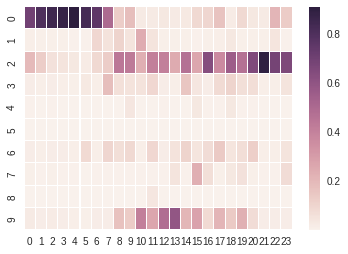

In [22]:

clf = HierarchicalAllDirichletCategoricalModel()
clf.fit(X_train, y_train)
timezone_max = clf.score(X_test, y_test)

In [23]:
print (X_test[:,0])

df = pd.DataFrame({'sep_hour':X_test[:,0],
                   'location':y_test })
ct = pd.crosstab( df['location'] , df['sep_hour']).apply(lambda r: r/r.sum(), axis=0)
print (ct)
print (timezone_max)

total_prediction = 0
for timezone, maxInTime in enumerate(timezone_max):
    print (ct[timezone][maxInTime],
           ct[timezone]['All'], 
           ct[timezone][maxInTime]/ ct[timezone]['All'])
    total_prediction += (ct[timezone][maxInTime]/ ct[timezone]['All'])

print (total_prediction/len(timezone_max))

[ 6 15 12 ...,  7 18 19]
sep_hour        0         1         2         3         4         5   \
location                                                               
0         0.739863  0.917164  0.972711  0.975082  0.972363  0.952417   
1         0.022809  0.003881  0.001342  0.003432  0.007171  0.013617   
2         0.222272  0.067313  0.010737  0.000149  0.000000  0.004489   
3         0.004323  0.000299  0.000149  0.000149  0.000299  0.007332   
4         0.001193  0.000597  0.000000  0.000000  0.000000  0.000000   
5         0.000745  0.001493  0.003281  0.007610  0.007469  0.008529   
6         0.008348  0.009104  0.009693  0.013578  0.012698  0.013018   
7         0.000298  0.000149  0.000149  0.000000  0.000000  0.000000   
8         0.000000  0.000000  0.000000  0.000000  0.000000  0.000599   
9         0.000149  0.000000  0.001939  0.000000  0.000000  0.000000   

sep_hour        6         7         8         9     ...           14  \
location                              

KeyError: 'All'

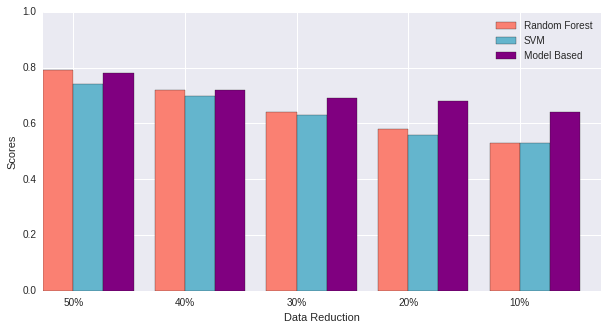

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set_color_codes()
data_usage = [50, 40, 30, 20, 10]
random_forest = [0.79, 0.72, 0.64, 0.58, 0.53]
svm = [0.74, 0.70, 0.63, 0.56, 0.53]
model_based = [0.78, 0.72, 0.69, 0.68, 0.64]

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

yvals = [4, 9, 2]
rects1 = ax.bar(ind, random_forest, width, color='salmon')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, svm, width, color='c')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, model_based, width, color='purple')

ax.set_ylim([0,1])
ax.set_ylabel('Scores')
ax.set_xlabel('Data Reduction')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('50%', '40%', '30%', '20%', '10%') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Random Forest', 'SVM', 'Model Based') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)

plt.show()

In [44]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

np.random.seed(sum(map(ord, "categorical")))

#titanic = sns.load_dataset("titanic")
tips = sns.load_dataset("tips")
#iris = sns.load_dataset("iris")
tips


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2
